# (Gen-)AI-Explorationsphase | Schulung IV

## Hands-On «Build your own RAG-Tool»

### Vorbereitungsschritte

Retrieval Augmented Generation (RAG), eine Möglichkeit eigene Daten als Kontext für LLMs bereitzustellen:
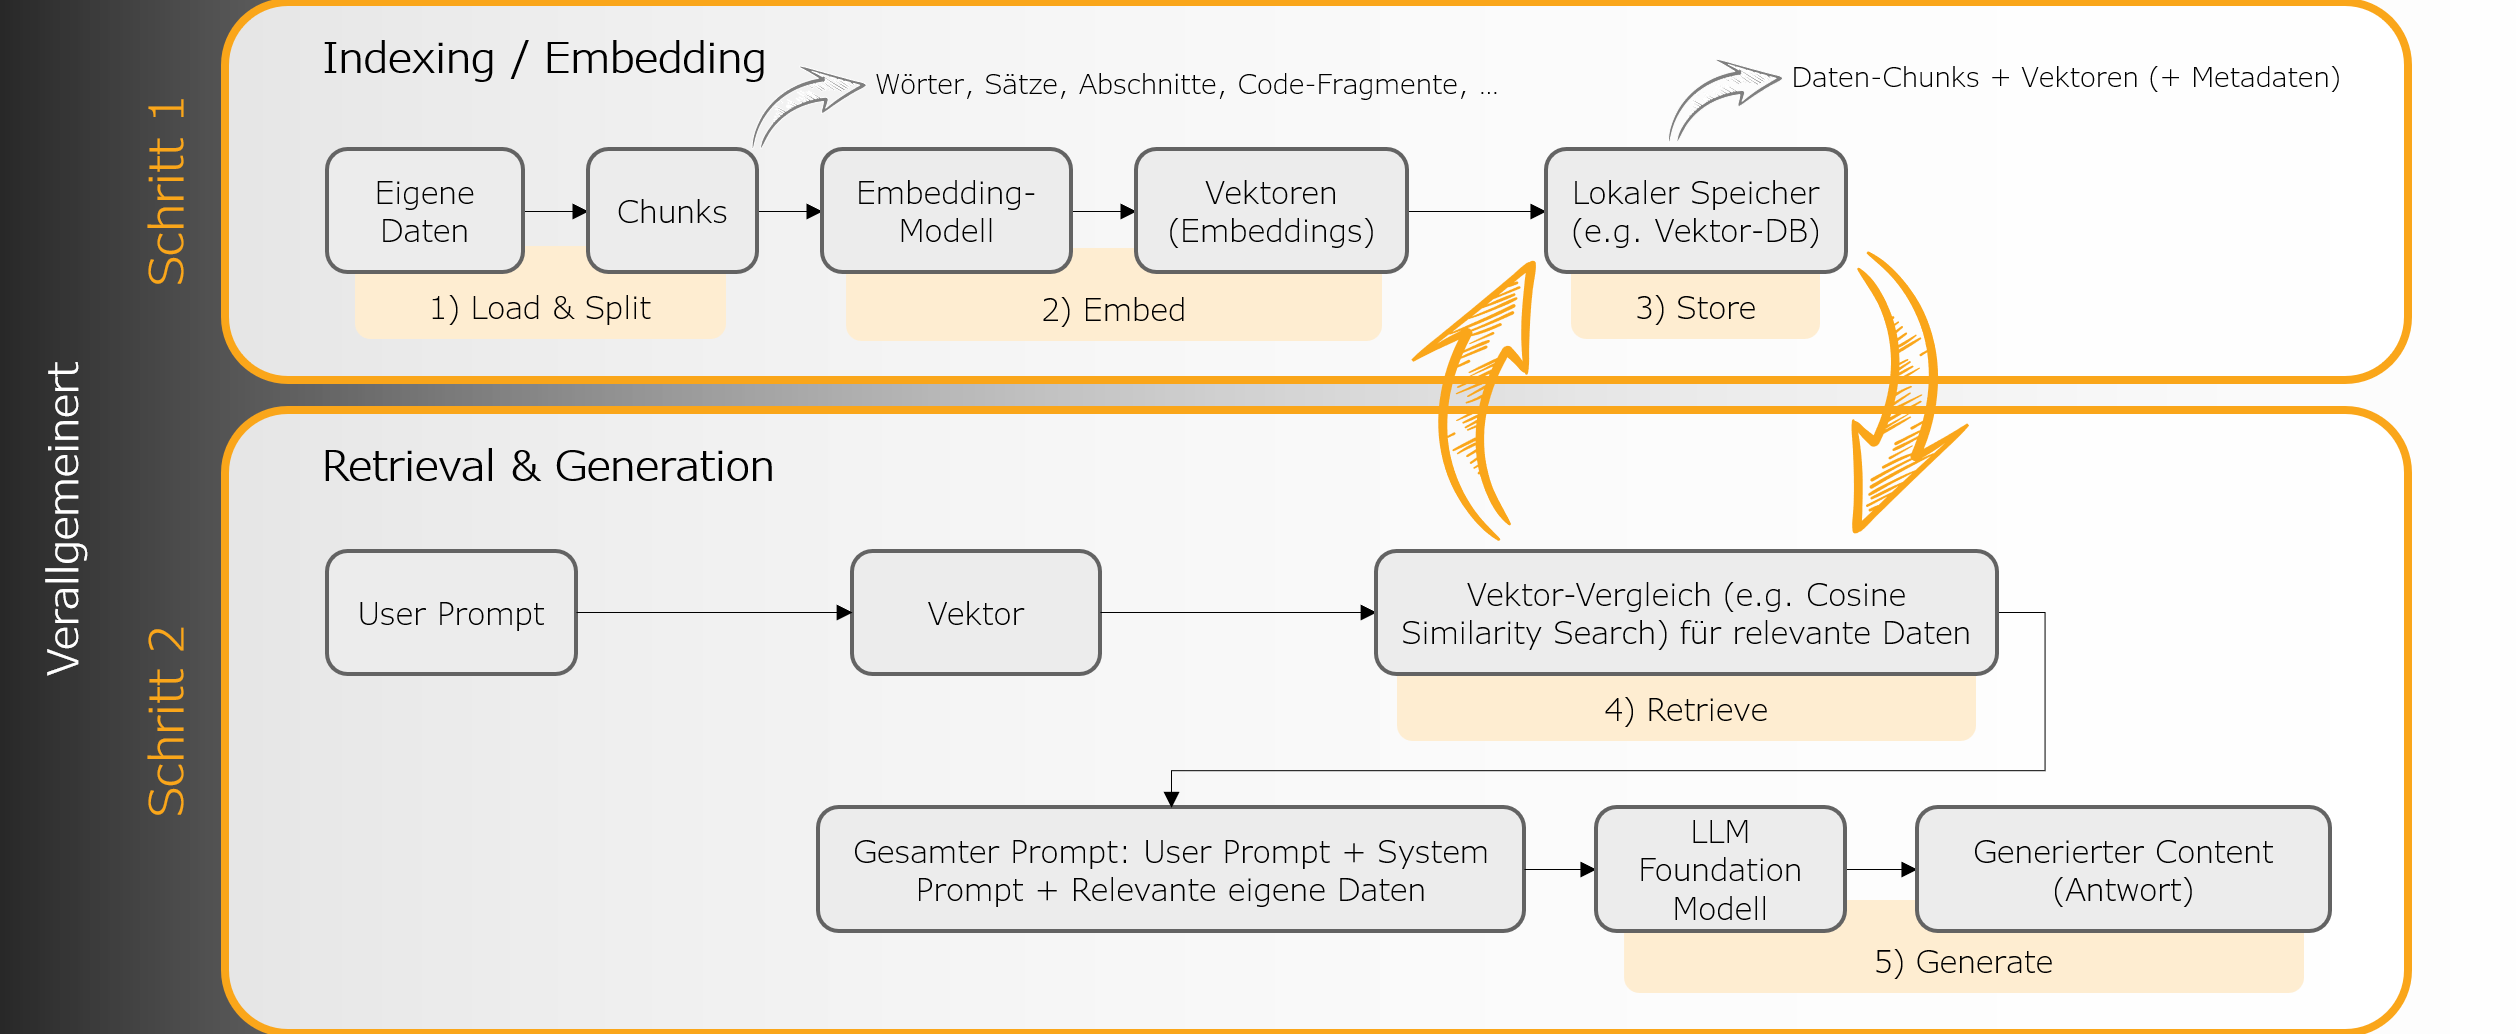

Installation der benötigten Packages: Wir installieren openai für API-Zugriff auf Embedding-Modelle (Generierung von Vektoren) und LLMs (Generierung von Text), sowie chromadb für die Speicherung und den Abruf von Vektoren/Kontext/Metadaten. PyPDF2 wird zum Extrahieren von Texten aus PDFs verwendet. Zudem nutzen wir tiktoken für die Tokenisierung (Wörter zu Tokens).

In [ ]:
# Installation notwendiger Packages
!pip install openai chromadb PyPDF2 tiktoken

Für das LLM und das Embedding nutzen wir die OpenAI-Modelle. Der Platzhalter für den OpenAI API-Key muss mit einem auf https://platform.openai.com/api-keys generierten API-Key ersetzt werden:

In [ ]:
# API-Key für OpenAI (hier ersetzen durch deinen tatsächlichen API-Schlüssel)
openai_api_key = "YOUR_OPENAI_API_KEY"

### Load & Split

Bevor wir überhaupt etwas verarbeiten können, brauchen wir Daten! Dazu laden wir ein PDF hoch, beispielsweise eine Detektivgeschichte von Sherlock Holmes! Dazu musst du auf der linken Seite dein PDF hochladen (Achtung, nur öffentliche Daten!). Natürlich können wir auch andere Daten wie bspw. Code hochladen. In unserem Fall bleiben wir aber beim PDF und extrahieren den Text. Diesen lassen wir uns im Anschluss anzeigen:

In [ ]:
# Import der notwendigen Module
from PyPDF2 import PdfReader

# Funktion zum PDF-Datei laden und Text extrahieren
def extract_text_from_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text()
    return text

# Pfad zur PDF-Datei (ersetzt durch den Pfad zu deiner Datei)
pdf_path = "/content/sherlock_holmes_detektivgeschichten_arthur_doyle.pdf"
pdf_text = extract_text_from_pdf(pdf_path)
print(pdf_text)

Uns fällt auf, dass wir nun einen grossen String haben. Darin ist die Geschichte enthalten, jedoch auch Garbage wie die Seitenzahlen. Hier gilt natürlich, dass um so höher die Qualität der Datengrundlage ist, um so besser funktioniert nachher unsere RAG-Pipeline. Wir verzichten jedoch an dieser Stelle auf ein Bereinigen der Daten. Als nächstes Splitten wir diesen grossen String in kleinere Häppchen, sogenante Chunks:

In [ ]:
# Funktion um Text in Chunks aufzuteilen
def split_text_into_chunks(text, chunk_size=500, overlap=100):
    chunks = []
    start = 0
    while start < len(text):
        end = min(start + chunk_size, len(text))
        chunk = text[start:end]
        chunks.append(chunk)
        start += chunk_size - overlap  # Überschneidung von Textstücken für besseren Kontext
    return chunks

# Splitting
chunks = split_text_into_chunks(pdf_text)

# Ausgabe der Anzahl der Chunks und einer Vorschau des ersten Chunks
print(f"Anzahl der Chunks: {len(chunks)}")
print('')
print(f"Erster Chunk:\n{chunks[0]}")

Der Text ist nun in handhabbare Chunks aufgeteilt, die später für das Embedding und die Speicherung in ChromaDB verwendet werden können. Dazu haben wir den Text in Chunks von 500 Zeichen aufgeteilt, wobei sich die Chunks jeweils zu 100 Zeichen überlappen um den Kontext zwischen den Chunks zu verbessern. Dies ist eine sehr einfache Art des Chunking, welche aber gut bei reinem Fliesstext funktioniert. Alternativ kann man die Chunks natürlich beliebig aufteilen, bspw. für Code ganze Funktionen mit Beschreibungen. Auch haben wir später die Möglichkeit, Chunks mit Metadaten für die Vektordatenbank zu versehen.

### Embed & Store

Als nächstes erstellen wir eine Vektor-Datenbank und embedden darin unsere Chunks. Dazu nehmen wir die weit verbreitete ChromaDB und greifen auf das OpenAI Embedding Modell Ada-002 per API zu. Wir persistieren die ChromaDB, damit wir diese später auch wieder laden könnten.

In [ ]:
# Import der notwendigen Module
from openai import OpenAI
import chromadb
from chromadb.config import Settings

# Initialisierung des ChromaDB-Clients (Datenbank-Connection)
persistent_path = "chroma_db"
client_chroma = chromadb.PersistentClient(path=persistent_path, settings=Settings())

# Connection zu OpenAI
client_openai = OpenAI(api_key=openai_api_key)

# Embedding-Modell & -Funktion
def get_openai_embedding(chunk, model="text-embedding-ada-002"):
   text = chunk.replace("\n", " ")
   return client_openai.embeddings.create(input=[chunk], model=model).data[0].embedding

Nun können wir die zuvor erstellten Chunks in die Vektor-Datenbank speichern. Dazu erstellen wir eine neue Collection, eine Art Ordner in unserer Vektor-Datenbank. Davon können wir mehrere erstellen und so Dokumente/Dokumentgruppen auseinanderhalten.

In [ ]:
# Wir benennen unsere Collection
collection_name = "sherlock_holmes"

# Wir überprüfen, ob die Collection bereits existiert, falls nicht, erstellen wir eine neue Collection für unsere Sherlock Holmes Geschichte
try:
    collection = client_chroma.create_collection(collection_name)
    print(f"Neue Sammlung '{collection_name}' wird erstellt.")

# Falls die Collection jedoch bereits existiert, wird sie durch einen neue, leere Collection ersetzt
except:
    client_chroma.delete_collection(collection_name)
    collection = client_chroma.create_collection(collection_name)
    print(f"Bestehende Sammlung '{collection_name}' wird ersetzt.")

# Embedding pro Chunk erstellen und Chunks in der Collection speichern
for i, chunk in enumerate(chunks):
    embedding = get_openai_embedding(chunk)
    doc_id = f"doc_{i}"
    collection.add(
        ids=[doc_id],
        documents=[chunk],
        embeddings=[embedding],
        metadatas=[{"chunk_id": i}] # Wir können hier beliebig Metadaten mitgeben. Beispielsweise die Seitenanzahl, oder bei Code der Link zw. Funktion und Methode
    )

# Erfolgsmeldung
print("Embedding erfolgreich abgeschlossen")

Wir haben obige Collection persisitiert. Das heisst, dass wir diese abgespeichert haben. Damit können wir diese auch laden, ohne das Embedding nochmals durchführen zu müssen! Wir schauen zuerst, welche Collections persisitiert wurden:

In [ ]:
# Liste alle vorhandenen Collections in der Chroma-Datenbank auf
collections = client_chroma.list_collections()
for col in collections:
    print(f"Collection Name: {col.name}, Chunk Count: {col.count()}")

Bevor wir die entsprechende Collection laden:

In [ ]:
# Import der notwendigen Module
import os

# Überprüfe, ob der Pfad zur persistenten Datenbank existiert und lade die existierende Collection, wenn der Pfad vorhanden ist
if os.path.exists(persistent_path):
        collection = client_chroma.get_collection(collection_name)

# Erfolgsmeldung
print("Laden erfolgreich abgeschlossen")

### Retrieve

Wir können nun obige Embeddings testen indem wir ein Query an obige Collection absetzen. ChromaDB wird dann die n (semantisch) ählichsten Resultate zurückgeben.

In [ ]:
# Anzahl Resultate die wir finden wollen
n_results = 3

# Text, zu welchem wir die Vektordatenbank durchsuchen wollen
query = "Was ist die Anzahl Sherlock Holmes Geschichten?" # Alternativ: Was ist die Wohnung von Sherlock Holmes und Watson?

# Wir nutzen auch hier das Embedding-Modell von OpenAI
results = collection.query(
    query_embeddings=get_openai_embedding(query),
    n_results=n_results
)

# Ergebnisse anzeigen (gekürzt auf die ersten 100 Zeichen)
for i in range(n_results):
    print(f"Chunk/Text: {results['documents'][0][i][:100]} (...)")
    print(f"Score: {results['distances'][0][i]}") # Der Abstand zeigt die Ähnlichkeit an (kleiner ist besser)
    print(f"Metadaten: {results['metadatas'][0][i]}")
    print('')

### Generate

Diese relevantesten Chunks können wir nun an ein LLM geben, um uns unsere Frage in natürlicher Sprache beantworten zu lassen:

In [ ]:
# Relevanteste Chunks von oben zu einem String verknüpfen
context = ''
for i in range(n_results):
    context += "\n\n"
    context += results['documents'][0][i]

# Definiere den System-Prompt und dem User-Prompt
system_prompt = "Du bist ein hilfreicher Assistent, welcher Fragen zu Sherlock Holmes auf Basis von zur Verfügung gestelltem Kontext beantwortet."
user_prompt = f"Nutze den folgenden Kontext, um die Frage '{query}' zu beantworten: {context}"

# Sende die Anfrage an GPT-4o-mini
response_openai = client_openai.chat.completions.create(
    model = "gpt-4o-mini",
    messages = [
        {
            "role": "system",
            "content": system_prompt
        },
        {
            "role": "user",
            "content": user_prompt
        }
    ]
)

# Ausgabe der Antwort
print(response_openai.choices[0].message.content)

### Weiterführende Literatur

Um uns das Coding zu vereinfachen/beschleunigen, können wir auch die vielen Bausteine von Langchain nutzen. Langchain besitzt bereits viele vordefinierte Funktionen und bietet die Möglichkeit, eine RAG-Pipeline schlank zu bauen. Unten gibt es einige weiterführende Literatur zu Langchain, auch zusammen mit Ollama.

Quellen:
1. [Langchain: Build a Retrieval Augmented Generation](https://python.langchain.com/v0.2/docs/tutorials/rag/#concepts)
2. [Langchain: Build a Local RAG Application](https://python.langchain.com/v0.2/docs/tutorials/local_rag/)
3. [Medium: Understanding RAG (Retrieval-Augmented Generation) with a practical (simple) example](https://michael-scherding.medium.com/understanding-rag-retrieval-augmented-generation-with-a-practical-simple-example-40200d0019d5)
4. [Medium: Intro of Retrieval Augmented Generation (RAG) and application demos](https://medium.com/@henryhengluo/intro-of-retrieval-augmented-generation-rag-and-application-demos-c1d9239ababf)
5. [ChromaDB: Getting started](https://docs.trychroma.com/getting-started)
6. [GitHub: Basic RAG Pipeline with LlamaIndex](https://github.com/HenryHengLUO/Retrieval-Augmented-Generation-Intro-Project/blob/main/code/1_Basic_RAG_Pipeline.ipynb)

## Hands-On «Build your own Guardrails»

### Beispiele

**Maximal Length:** Dieses Guardrail dient dazu, die maximale Länge einer Antwort, die von einem Language Model (LLM) generiert wird, zu überprüfen und sicherzustellen, dass sie eine bestimmte Zeichenanzahl (in diesem Fall 100 Zeichen) nicht überschreitet. Es soll verhindern, dass das LLM zu lange Antworten liefert, die möglicherweise unerwünscht oder unpraktisch sind. Wenn die Antwort die festgelegte Länge überschreitet, wird eine entsprechende Warnung ausgegeben.

In [ ]:
# Define a maximum length for the LLM response
max_length = 100

def check_response_length(response):
    if len(response) > max_length:
        return False, f"Response too long: {len(response)} characters."
    return True, "Response length is acceptable."

# Example LLM response
llm_response = "This is a sample response from the LLM."

# Check if the response length is acceptable
is_acceptable, message = check_response_length(llm_response)
if not is_acceptable:
    print(message)
else:
    print("LLM response is of acceptable length:", llm_response)

Das gleiche Guardrail kann auch mittels output_length direkt ans Modell als Parameter mitgegeben werden.
Solche Guardrails sind sowohl beim Input als auch beim Output nützlich, um die Generierung von unnötigen Tokens (und somit auch Kosten) zu vermeiden.

In [ ]:
# Import der notwendigen Module
from openai import OpenAI

# Connection zu OpenAI
client_openai = OpenAI(api_key=openai_api_key)

# Definiere den System-Prompt und dem User-Prompt
system_prompt = "Du bist ein hilfreicher Assistent."
user_prompt = f"Was ist Azure"

output_length = 10

# Sende die Anfrage an GPT-4o-mini
response_openai = client_openai.chat.completions.create(
    model = "gpt-4o-mini",
    messages = [
        {
            "role": "system",
            "content": system_prompt
        },
        {
            "role": "user",
            "content": user_prompt
        }
    ],
    max_tokens = output_length
)

# Ausgabe der Antwort
print(response_openai.choices[0].message.content)

**Regex Filter:** Dieses Guardrail dient dazu, spezielle Zeichen (wie Satzzeichen und Symbole) aus einer vom Language Model (LLM) generierten Antwort zu entfernen. Es verwendet reguläre Ausdrücke (Regex), um alle nicht alphanumerischen Zeichen (außer Leerzeichen) durch eine leere Zeichenkette zu ersetzen. Dies kann nützlich sein, um die Ausgabe des LLMs zu bereinigen und nur Buchstaben, Zahlen und Leerzeichen zuzulassen. So wird die Antwort vereinfacht und von unerwünschten Sonderzeichen befreit.

In [ ]:
# Import der notwendigen Module
import re

# Use regex to replace all non-alphanumeric characters (except spaces) with an empty string
def filter_special_characters(response):
    filtered_response = re.sub(r'[^A-Za-z0-9\s]', '', response)
    return filtered_response

# Example LLM response with special characters
llm_response = "Hello, world! Welcome to AI-powered @chatbot #123."

# Filter the special characters from the response
filtered_response = filter_special_characters(llm_response)

print("Original LLM response:", llm_response)
print("Filtered LLM response:", filtered_response)

**Profanity Check:** Dieses Guardrail dient dazu, Texteingaben auf profane oder unerwünschte Wörter zu überprüfen. Es vergleicht den eingegebenen Text (in Kleinbuchstaben) mit einer Liste von verbotenen Wörtern. Wenn eines dieser verbotenen Wörter im Text gefunden wird, gibt die Funktion eine Warnung zurück, die darauf hinweist, dass das Wort nicht erlaubt ist. Falls keine verbotenen Wörter gefunden werden, meldet die Funktion, dass keine Profanität erkannt wurde. Dies ist nützlich, um sicherzustellen, dass die generierten oder eingegebenen Texte keine unangemessenen Inhalte enthalten.

In [ ]:
def profanity_check(input_text, banned_words):
    # Convert the input text to lowercase
    lowered_text = input_text.lower()

    # Check each banned word against the input text
    for word in banned_words:
        if word.lower() in lowered_text:
            return f"Profanity detected: '{word}' is not allowed."

    return "No profanity detected."

# Example usage
input_text = "This is an example of a Bad Word."
banned_words = ["bad", "ugly", "nasty"]

result = profanity_check(input_text, banned_words)
print(result)

Profanity detected: 'bad' is not allowed.


### Weiterführende Literatur

Quellen:
1. [LLM Guard Playground](https://huggingface.co/spaces/protectai/llm-guard-playground)
2. [Guardrail Hub](https://hub.guardrailsai.com/)
3. [Prompt Injections](https://huggingface.co/spaces/protectai/prompt-injection-benchmark)
4. [Secret Agent](https://huggingface.co/spaces/ml6team/secret-agent-guardrail-challenge)
5. [NeMo](https://www.nvidia.com/en-us/ai-data-science/products/nemo/)
